#### From Kevin

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import tree

In [2]:
df = pd.read_csv('train.csv', index_col='PassengerId')
df_test = pd.read_csv('test.csv', index_col='PassengerId')
df = df.append(df_test)

C:\Users\thanm\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


C:\Users\thanm\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


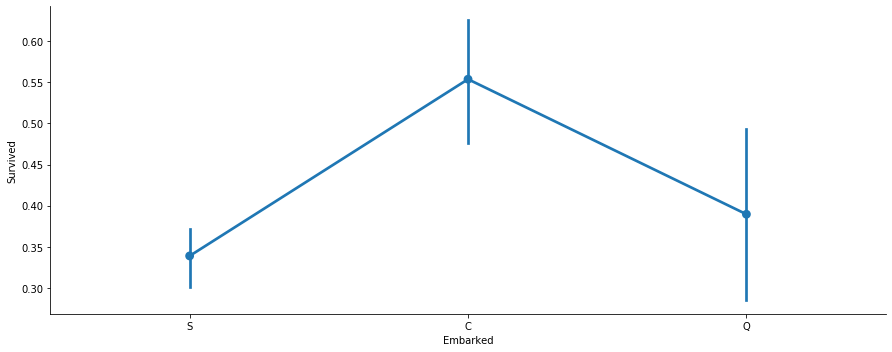

In [3]:
# Fill embarked
# A quick inspect shows that here are 2 embarked values missing. Since this number is
# small, we fill the missing values with the most common class 'S'.
# As demonstrated in the plot, there is definitely a correlation between embarked and 
# the survival rate. Passengers from port 'Southampton' have only 34% of survival rate 
# while those from the port 'Cherbourg' have 55% chance.
df.Embarked = df.Embarked.fillna('S')
axes = sns.factorplot('Embarked','Survived', data=df, aspect = 2.5)
df.Fare = df.Fare.fillna(df.Fare.mean())

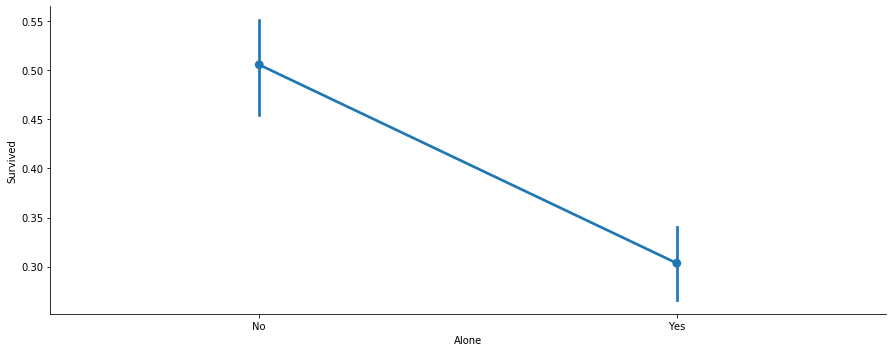

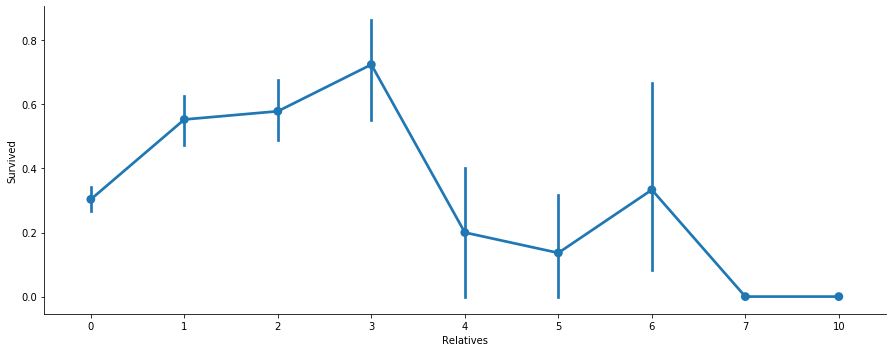

In [4]:
# Add features called Alone and Relatives
# Passengers traveled with families have higher survival rate than travel alone. Also, 
# passengers with 2 to 3 family members on board tends to have better chance of survival.
# As demonstrated in the plot, passenders travaled with 3 family members have 70% survival rate
# while passenger traveled with large family, 7-8 members have 0% survival rate.

df['Relatives'] = df['SibSp'] + df['Parch']
df.loc[df['Relatives'] > 0, 'Alone'] = 'No'
df.loc[df['Relatives'] == 0, 'Alone'] = 'Yes'
axes = sns.factorplot('Alone','Survived', data=df, aspect = 2.5)
axes = sns.factorplot('Relatives','Survived', data=df, aspect = 2.5)

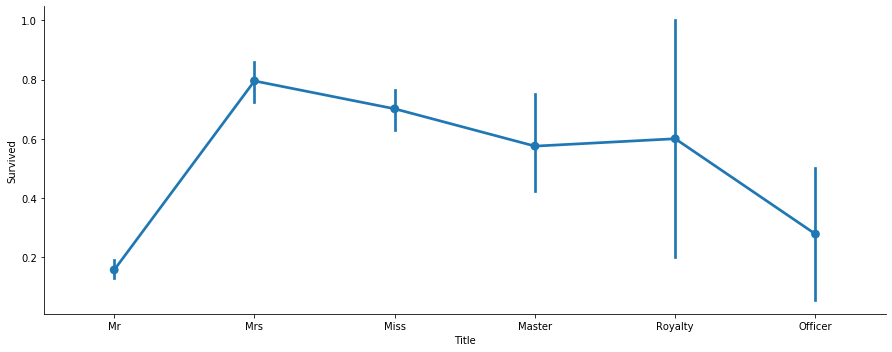

In [5]:
# Extract the passenger's Title from Name
# We created an additonal features called Title to explore the correlation between survival rate
# based on the passenger's social status. The titles can be classified into 3 main categories,
# Royalty, Workers and Civilians. Class worker includes Master and Officers where Offers have
# only 30% survival rate while Masters have about 60%. Royalites also have a high survival rate
# at just above 60%. On the other hand, male civilians do not stand much chance to survive. Only
# 10% of male who are civilian survived. Guess Jack didn't make the cut :(
df2 = df
df2['Title'] = df2.Name
df2.Title = df2.Title.replace(regex={
    r'.*, Capt.*': 'Officer',
    r'.*, Col.*': 'Officer',
    r'.*, Major.*': 'Officer',
    r'.*, Jonkheer.*': 'Royalty',
    r'.*, Don.*': 'Royalty',
    r'.*, Sir.*': 'Royalty',
    r'.*, Dr.*': 'Officer',
    r'.*, Rev.*': 'Officer',
    r'.*, the Countess.*': 'Royalty',
    r'.*, Mme.*': 'Mrs',
    r'.*, Mlle.*': 'Miss',
    r'.*, Ms.*': 'Mrs',
    r'.*, Mrs.*': 'Mrs',
    r'.*, Mr.*': 'Mr',
    r'.*, Miss.*': 'Miss',
    r'.*, Master.*': 'Master',
    r'.*, Lady.*': 'Royalty'
})
axes = sns.factorplot('Title','Survived', data=df2, aspect = 2.5)

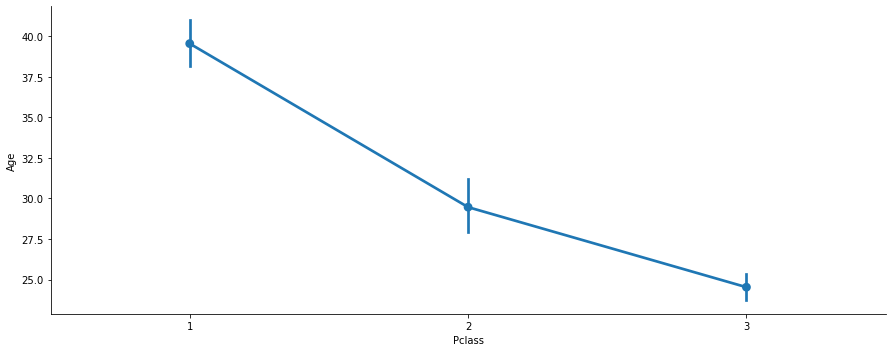

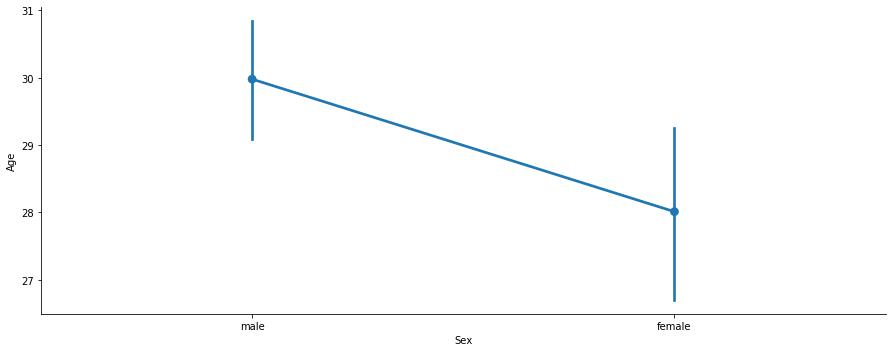

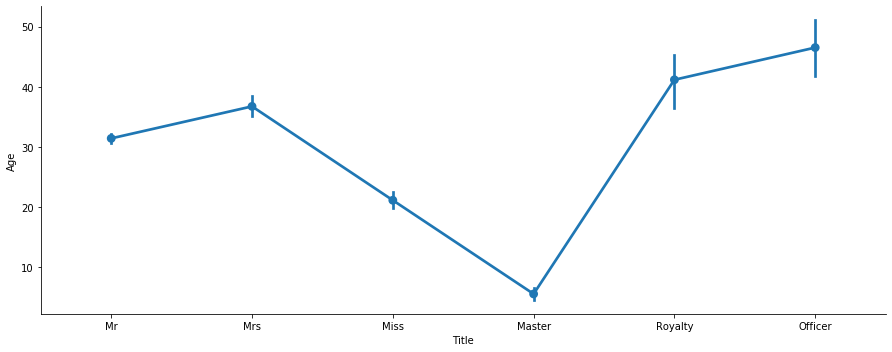

In [6]:
# fill age based on sex, class and title
# A quick inspect using .info() shows there are 263 passengers have the value Age missing. This
# is quite a large amount considering the dataset have only 1309 samples. Filling the age with
# mean would be an option, but may not be the best approach. Instead, we use the median based on
# three other features, Sex, Pclass and Title. As demonstrated in the plots, the passenger's age
# are highly influenced by these three features.
df3 = df2
grouped = df3.groupby(['Sex', 'Pclass', 'Title'])
grouped_median = grouped.median()
grouped_median = grouped_median.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

def fill_age(row):
    condition = (
        (grouped_median['Sex'] == row['Sex']) &
        (grouped_median['Title'] == row['Title']) &
        (grouped_median['Pclass'] == row['Pclass'])
    )
    if np.isnan(grouped_median[condition]['Age'].values[0]):
        condition = (
            (grouped_median['Sex'] == row['Sex']) &
            (grouped_median['Pclass'] == row['Pclass'])
        )
    return grouped_median[condition]['Age'].values[0]

df3['Age'] = df3.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
axes = sns.factorplot('Pclass','Age', data=df2, aspect = 2.5)
axes = sns.factorplot('Sex','Age', data=df2, aspect = 2.5)
axes = sns.factorplot('Title','Age', data=df2, aspect = 2.5)

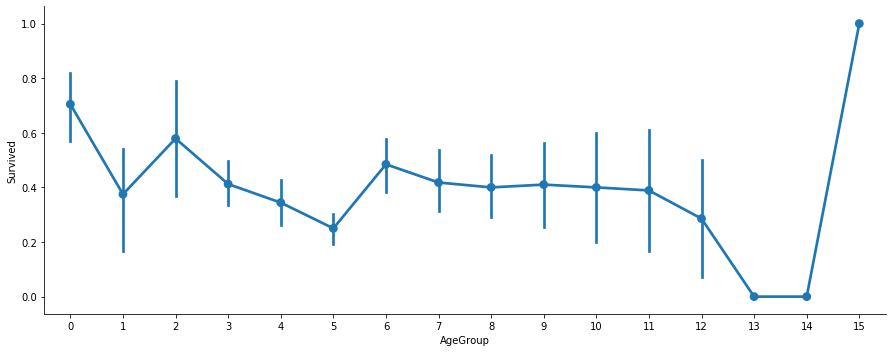

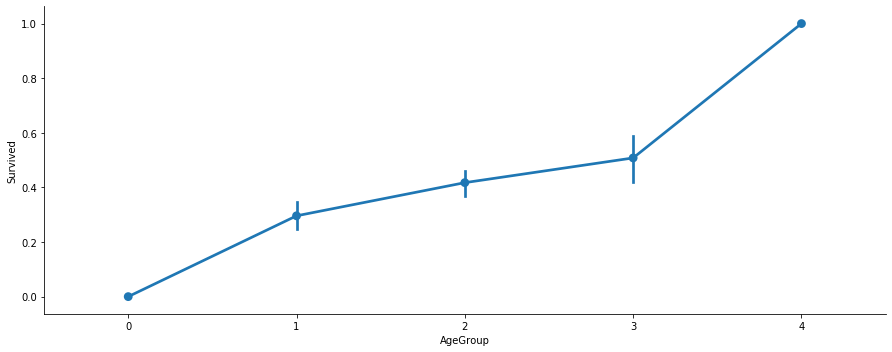

In [7]:
# Add a feature called AgeGroup

bins = list(range(0, 81, 5))
labels = list(range(len(bins)-1))
df3['AgeGroup'] = pd.cut(df3.Age, bins, labels=labels, include_lowest=True)
axes = sns.factorplot('AgeGroup','Survived', data=df3, aspect = 2.5)
df3.AgeGroup = df3.AgeGroup = df.AgeGroup.replace({
    0:3, 
    1:1, 
    2:2, 
    3:2, 
    4:2, 
    5:1, 
    6:2, 
    7:2, 
    8:1, 
    9:3, 
    10:3, 
    11:3, 
    12:1, 
    13:0,
    14:0,
    15:4
})

# let's see how it's distributed train_df['Age'].value_counts()
axes = sns.factorplot('AgeGroup','Survived', data=df3, aspect = 2.5)

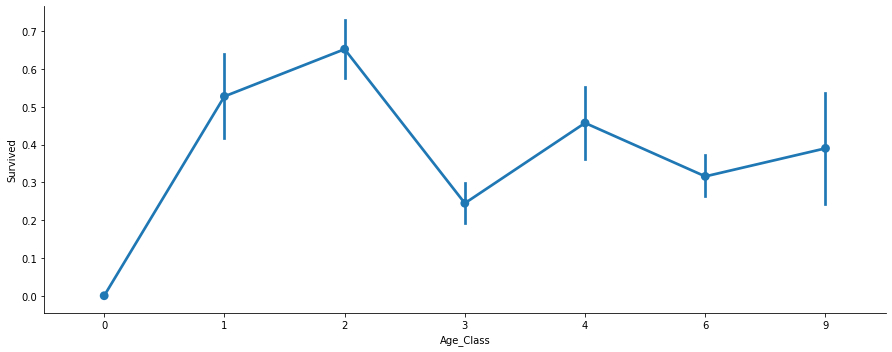

In [8]:
# Add a feature called Age Class

df3['Age_Class']= df3['AgeGroup']* df3['Pclass']
axes = sns.factorplot('Age_Class','Survived', data=df3, aspect = 2.5)

In [9]:
# Convert fare to categories
df3.loc[df3['Fare'] <= 7.91, 'Fare'] = 0
df3.loc[(df3['Fare'] > 7.91) & (df3['Fare'] <= 14.454), 'Fare'] = 1
df3.loc[(df3['Fare'] > 14.454) & (df3['Fare'] <= 31), 'Fare'] = 2
df3.loc[(df3['Fare'] > 31) & (df3['Fare'] <= 99), 'Fare'] = 3
df3.loc[(df3['Fare'] > 99) & (df3['Fare'] <= 250), 'Fare'] = 4
df3.loc[ df3['Fare'] > 250, 'Fare'] = 5
df3['Fare'] = df3['Fare'].astype(int)

In [10]:
# %%
df3['Fare_Per_Person'] = df3['Fare']/(df3['Relatives']+1)
df3['Fare_Per_Person'] = df3['Fare_Per_Person'].astype(int)

In [11]:
df4 = df3
df4 = df4.loc[:, ['Sex', 'Title', 'AgeGroup', 'Fare', 'Relatives', 'Age_Class', 'Embarked', 'Pclass']]
#df4 = df4.loc[:, ['Sex', 'Title', 'AgeGroup', 'Fare', 'Relatives', 'Embarked', 'Pclass']]
#df4 = df4.loc[:, ['Sex', 'Title', 'SibSp', 'AgeGroup', 'Fare_Per_Person', 'Age_Class', 'Fare', 'Relatives', 'Embarked', 'Pclass']]
labels = df3['Survived'].dropna()
df4.head()

,Sex,Title,AgeGroup,Fare,Relatives,Age_Class,Embarked,Pclass
PassengerId,,,,,,,,
1,male,Mr,2,0,1,6,S,3
2,female,Mrs,2,3,1,2,C,1
3,female,Miss,1,1,0,3,S,3
4,female,Mrs,2,3,1,2,S,1
5,male,Mr,2,1,0,6,S,3


In [12]:
#map sex, embarked, and title to numeric
ports = {"S": 0, 'C':1, 'Q':2}
num_sex = {"male":0,"female":1}
num_title = {"Mr": 0, "Mrs":1, "Miss": 2, "Master":3,"Royalty":4,"Officer":5}
df4['Sex'] = df4['Sex'].map(num_sex)
df4['Embarked'] = df4['Embarked'].map(ports)
df4['Title'] = df4['Title'].map(num_title)
df4
df5 = df4.drop('Age_Class', axis =1)
df5.head()

,Sex,Title,AgeGroup,Fare,Relatives,Embarked,Pclass
PassengerId,,,,,,,
1,0,0,2,0,1,0,3
2,1,1,2,3,1,1,1
3,1,2,1,1,0,0,3
4,1,1,2,3,1,0,1
5,0,0,2,1,0,0,3


In [13]:
from sklearn.preprocessing import StandardScaler

numeric_features = list(df5.select_dtypes(include=['int64', 'float64', 'int32']).columns)
scaler = StandardScaler()
df5[numeric_features] = scaler.fit_transform(df5[numeric_features])
df5.head()

,Sex,Title,AgeGroup,Fare,Relatives,Embarked,Pclass
PassengerId,,,,,,,
1,-0.743497,-0.715617,0.353004,-1.248109,0.073352,-0.603436,0.841916
2,1.344995,0.179930,0.353004,1.124265,0.073352,0.927373,-1.546098
3,1.344995,1.075478,-1.091002,-0.457318,-0.558346,-0.603436,0.841916
4,1.344995,0.179930,0.353004,1.124265,0.073352,-0.603436,-1.546098
5,-0.743497,-0.715617,0.353004,-0.457318,-0.558346,-0.603436,0.841916


In [14]:
# # One-Hot encoding
# encode_features = list(df4.select_dtypes(include=['object']).columns)
# for feature in encode_features:
#     df4 = pd.concat([df4, pd.get_dummies(df4[feature], prefix=feature)],axis=1)
#     df4.drop(feature, axis = 1, inplace=True)

In [24]:
# Train a RandomForst model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
df_train = df5[:891]
y = labels.to_numpy()
X = df_train.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = RandomForestClassifier(n_estimators=1888, min_samples_split=5, min_samples_leaf=3, max_features='sqrt', max_depth=11, bootstrap=False)
#clf = RandomForestClassifier(n_estimators=1200, min_samples_split=4, min_samples_leaf=1, max_features='auto', max_depth=5, bootstrap=True)

clf.fit(X, y)
print('RandomForst, Train score:', cross_val_score(clf, X_train, y_train, cv=10).mean())
print('RandomForst, Test score:', cross_val_score(clf, X_test, y_test, cv=10).mean())


RandomForst, Train score: 0.8258909009613236
RandomForst, Test score: 0.8261437908496732


In [16]:
df_train.head()

,Sex,Title,AgeGroup,Fare,Relatives,Age_Class,Embarked,Pclass
PassengerId,,,,,,,,
1,0,0,2,0,1,6,0,3
2,1,1,2,3,1,2,1,1
3,1,2,1,1,0,3,0,3
4,1,1,2,3,1,2,0,1
5,0,0,2,1,0,6,0,3


In [25]:
importances = pd.DataFrame({'feature':df_train.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(25)

,importance
feature,
Title,0.312
Sex,0.246
Pclass,0.153
Relatives,0.114
Fare,0.096
AgeGroup,0.048
Embarked,0.032


In [18]:
# Train a Decision Tree model
# clf = tree.DecisionTreeClassifier()
# clf.fit(X_train, y_train)
# #print(clf.score(X_test, y_test))
# print('DecisionTree, Train score:', cross_val_score(clf, X_train, y_train, cv=20).mean())
# print('DecisionTree, Test score:', cross_val_score(clf, X_test, y_test, cv=20).mean())

In [26]:
# Add result to test set
res = clf.predict(df5[891:].to_numpy()).astype(int)
df_test['Survived'] = res

In [27]:
# Prepare result file
df_res = df_test.loc[:,'Survived']
df_res.to_csv('results.csv', index = True, header=True)

In [29]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(40,60, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [3, 4, 5, 6, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,5]
# Method of selecting samples for training each tree
bootstrap = [True, False]

max_features = [2, 4, 6, 8]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# {'bootstrap': [True, False],
#  'max_depth': [40, 45, 50, 55, 60, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [600, 650, 700, 750, 800, 850, 900, 950, 1000]}


rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)
print('Score:', rf_random.score(X, y))
print('Best parameters:', rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.2min finished


Score: 0.8765432098765432
Best parameters: {'n_estimators': 400, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 60, 'bootstrap': True}


### PCA Analysis

In [22]:
from sklearn.decomposition import PCA

In [59]:
pca =PCA().fit(X_train)
X_train_pca=pca.transform(X_train)

n_pcs = pca.components_.shape[0]
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = df5.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
d = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
df6 = pd.DataFrame(d.items())
# df6

explained_variance = pca.explained_variance_ratio_
explained_variance
# components = pca.components_
# # for item in zip(df5.columns, explained_variance):
# #     print(item)
# components

array([0.32982572, 0.1961268 , 0.14665337, 0.12942501, 0.10815802,
       0.06611218, 0.0236989 ])

### Feature Combinations

In [60]:
from itertools import combinations 
comb = list(combinations(df5.columns, 1))

i = 1
for c in comb:
    feature_list = [x for x in c]
    df_t = df_train[df_train.columns.intersection(feature_list)]

    y = labels.to_numpy()
    X = df_t.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = RandomForestClassifier(n_estimators=400, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', max_depth=60, bootstrap=True)
    clf.fit(X, y)
    print('Features: ', feature_list)
    print(i,' RandomForst, Train score:', cross_val_score(clf, X_train, y_train, cv=10).mean())
    print(i,' RandomForst, Test score:', cross_val_score(clf, X_test, y_test, cv=10).mean())
    i+=1

Features:  ['Sex']
1  RandomForst, Train score: 0.7809970936731501
1  RandomForst, Test score: 0.8103027175782594
Features:  ['Title']
2  RandomForst, Train score: 0.7966163648558015
2  RandomForst, Test score: 0.7654110767113863
Features:  ['AgeGroup']
3  RandomForst, Train score: 0.6096031746031747
3  RandomForst, Test score: 0.6031647746818025
Features:  ['Fare']
4  RandomForst, Train score: 0.6559993293091886
4  RandomForst, Test score: 0.5959064327485379
Features:  ['Relatives']
5  RandomForst, Train score: 0.6643192488262912
5  RandomForst, Test score: 0.6643790849673202
Features:  ['Embarked']
6  RandomForst, Train score: 0.6543231611893583
6  RandomForst, Test score: 0.5867045063639491
Features:  ['Pclass']
7  RandomForst, Train score: 0.6575
7  RandomForst, Test score: 0.7191606467148263


In [61]:
from itertools import combinations 
comb = list(combinations(df5.columns, 2))

i = 1
for c in comb:
    feature_list = [x for x in c]
    df_t = df_train[df_train.columns.intersection(feature_list)]

    y = labels.to_numpy()
    X = df_t.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = RandomForestClassifier(n_estimators=400, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', max_depth=60, bootstrap=True)
    clf.fit(X, y)
    print('Features: ', feature_list)
    print(i,' RandomForst, Train score:', cross_val_score(clf, X_train, y_train, cv=10).mean())
    print(i,' RandomForst, Test score:', cross_val_score(clf, X_test, y_test, cv=10).mean())
    i+=1

Features:  ['Sex', 'Title']
1  RandomForst, Train score: 0.7907897384305834
1  RandomForst, Test score: 0.7922944616443067
Features:  ['Sex', 'AgeGroup']
2  RandomForst, Train score: 0.7765845070422535
2  RandomForst, Test score: 0.8267973856209151
Features:  ['Sex', 'Fare']
3  RandomForst, Train score: 0.7737410765965657
3  RandomForst, Test score: 0.8094427244582043
Features:  ['Sex', 'Relatives']
4  RandomForst, Train score: 0.7950827185334227
4  RandomForst, Test score: 0.7934640522875818
Features:  ['Sex', 'Embarked']
5  RandomForst, Train score: 0.7849999999999999
5  RandomForst, Test score: 0.7930856553147574
Features:  ['Sex', 'Pclass']
6  RandomForst, Train score: 0.7865414710485134
6  RandomForst, Test score: 0.7647058823529412
Features:  ['Title', 'AgeGroup']
7  RandomForst, Train score: 0.790829420970266
7  RandomForst, Test score: 0.7720502235982112
Features:  ['Title', 'Fare']
8  RandomForst, Train score: 0.7850743348982786
8  RandomForst, Test score: 0.7326281389748882
F

In [62]:
from itertools import combinations 
comb = list(combinations(df5.columns, 3))

i = 1
for c in comb:
    feature_list = [x for x in c]
    df_t = df_train[df_train.columns.intersection(feature_list)]

    y = labels.to_numpy()
    X = df_t.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = RandomForestClassifier(n_estimators=400, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', max_depth=60, bootstrap=True)
    clf.fit(X, y)
    print('Features: ', feature_list)
    print(i,' RandomForst, Train score:', cross_val_score(clf, X_train, y_train, cv=10).mean())
    print(i,' RandomForst, Test score:', cross_val_score(clf, X_test, y_test, cv=10).mean())
    i+=1

Features:  ['Sex', 'Title', 'AgeGroup']
1  RandomForst, Train score: 0.7751682316118936
1  RandomForst, Test score: 0.8087375300997591
Features:  ['Sex', 'Title', 'Fare']
2  RandomForst, Train score: 0.7932936507936509
2  RandomForst, Test score: 0.7933780529755763
Features:  ['Sex', 'Title', 'Relatives']
3  RandomForst, Train score: 0.819114129219763
3  RandomForst, Test score: 0.8709666322669418
Features:  ['Sex', 'Title', 'Embarked']
4  RandomForst, Train score: 0.7908394813324391
4  RandomForst, Test score: 0.7833333333333333
Features:  ['Sex', 'Title', 'Pclass']
5  RandomForst, Train score: 0.7907204337133915
5  RandomForst, Test score: 0.7598039215686275
Features:  ['Sex', 'AgeGroup', 'Fare']
6  RandomForst, Train score: 0.7600038587690526
6  RandomForst, Test score: 0.7487788097695219
Features:  ['Sex', 'AgeGroup', 'Relatives']
7  RandomForst, Train score: 0.8131651017214399
7  RandomForst, Test score: 0.7591331269349846
Features:  ['Sex', 'AgeGroup', 'Embarked']
8  RandomForst,

In [63]:
from itertools import combinations 
comb = list(combinations(df5.columns, 4))

i = 1
for c in comb:
    feature_list = [x for x in c]
    df_t = df_train[df_train.columns.intersection(feature_list)]

    y = labels.to_numpy()
    X = df_t.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = RandomForestClassifier(n_estimators=400, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', max_depth=60, bootstrap=True)
    clf.fit(X, y)
    print('Features: ', feature_list)
    print(i,' RandomForst, Train score:', cross_val_score(clf, X_train, y_train, cv=10).mean())
    print(i,' RandomForst, Test score:', cross_val_score(clf, X_test, y_test, cv=10).mean())
    i+=1

Features:  ['Sex', 'Title', 'AgeGroup', 'Fare']
1  RandomForst, Train score: 0.77369941873463
1  RandomForst, Test score: 0.7458720330237358
Features:  ['Sex', 'Title', 'AgeGroup', 'Relatives']
2  RandomForst, Train score: 0.8173233847529623
2  RandomForst, Test score: 0.8292225662194703
Features:  ['Sex', 'Title', 'AgeGroup', 'Embarked']
3  RandomForst, Train score: 0.7906810727377966
3  RandomForst, Test score: 0.8329033367733059
Features:  ['Sex', 'Title', 'AgeGroup', 'Pclass']
4  RandomForst, Train score: 0.8073876592890677
4  RandomForst, Test score: 0.8378568971448228
Features:  ['Sex', 'Title', 'Fare', 'Relatives']
5  RandomForst, Train score: 0.8215699754080037
5  RandomForst, Test score: 0.7927244582043343
Features:  ['Sex', 'Title', 'Fare', 'Embarked']
6  RandomForst, Train score: 0.7879799344009262
6  RandomForst, Test score: 0.8263673890608875
Features:  ['Sex', 'Title', 'Fare', 'Pclass']
7  RandomForst, Train score: 0.7865219092331769
7  RandomForst, Test score: 0.85522875

In [64]:
from itertools import combinations 
comb = list(combinations(df5.columns, 5))

i = 1
for c in comb:
    feature_list = [x for x in c]
    df_t = df_train[df_train.columns.intersection(feature_list)]

    y = labels.to_numpy()
    X = df_t.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = RandomForestClassifier(n_estimators=400, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', max_depth=60, bootstrap=True)
    clf.fit(X, y)
    print('Features: ', feature_list)
    print(i,' RandomForst, Train score:', cross_val_score(clf, X_train, y_train, cv=10).mean())
    print(i,' RandomForst, Test score:', cross_val_score(clf, X_test, y_test, cv=10).mean())
    i+=1

Features:  ['Sex', 'Title', 'AgeGroup', 'Fare', 'Relatives']
1  RandomForst, Train score: 0.8118287502794546
1  RandomForst, Test score: 0.7990196078431373
Features:  ['Sex', 'Title', 'AgeGroup', 'Fare', 'Embarked']
2  RandomForst, Train score: 0.7893058350100602
2  RandomForst, Test score: 0.7078431372549019
Features:  ['Sex', 'Title', 'AgeGroup', 'Fare', 'Pclass']
3  RandomForst, Train score: 0.8426699083389224
3  RandomForst, Test score: 0.760577915376677
Features:  ['Sex', 'Title', 'AgeGroup', 'Relatives', 'Embarked']
4  RandomForst, Train score: 0.8244790968030404
4  RandomForst, Test score: 0.7927072583419332
Features:  ['Sex', 'Title', 'AgeGroup', 'Relatives', 'Pclass']
5  RandomForst, Train score: 0.8315140845070422
5  RandomForst, Test score: 0.8160302717578259
Features:  ['Sex', 'Title', 'AgeGroup', 'Embarked', 'Pclass']
6  RandomForst, Train score: 0.8372317236753857
6  RandomForst, Test score: 0.7590127278981769
Features:  ['Sex', 'Title', 'Fare', 'Relatives', 'Embarked']
7

In [55]:
from itertools import combinations 
comb = list(combinations(df5.columns, 6))

i = 1
for c in comb:
    feature_list = [x for x in c]
    df_t = df_train[df_train.columns.intersection(feature_list)]

    y = labels.to_numpy()
    X = df_t.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = RandomForestClassifier(n_estimators=400, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', max_depth=60, bootstrap=True)
    clf.fit(X, y)
    print('Features: ', feature_list)
    print(i,' RandomForst, Train score:', cross_val_score(clf, X_train, y_train, cv=10).mean())
    print(i,' RandomForst, Test score:', cross_val_score(clf, X_test, y_test, cv=10).mean())
    i+=1

Features:  ['Sex', 'Title', 'AgeGroup', 'Fare', 'Relatives', 'Embarked']
1  RandomForst, Train score: 0.8190342052313884
1  RandomForst, Test score: 0.8330925352597178
Features:  ['Sex', 'Title', 'AgeGroup', 'Fare', 'Relatives', 'Pclass']
2  RandomForst, Train score: 0.8356025039123631
2  RandomForst, Test score: 0.8207430340557276
Features:  ['Sex', 'Title', 'AgeGroup', 'Fare', 'Embarked', 'Pclass']
3  RandomForst, Train score: 0.8076928236083166
3  RandomForst, Test score: 0.7920536635706914
Features:  ['Sex', 'Title', 'AgeGroup', 'Relatives', 'Embarked', 'Pclass']
4  RandomForst, Train score: 0.8354828973843057
4  RandomForst, Test score: 0.8383556931544547
Features:  ['Sex', 'Title', 'Fare', 'Relatives', 'Embarked', 'Pclass']
5  RandomForst, Train score: 0.820297898502124
5  RandomForst, Test score: 0.7643274853801171
Features:  ['Sex', 'AgeGroup', 'Fare', 'Relatives', 'Embarked', 'Pclass']
6  RandomForst, Train score: 0.825873015873016
6  RandomForst, Test score: 0.770175438596491

In [56]:
comb = list(combinations(df5.columns, 7))

i = 1
for c in comb:
    feature_list = [x for x in c]
    df_t = df_train[df_train.columns.intersection(feature_list)]

    y = labels.to_numpy()
    X = df_t.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = RandomForestClassifier(n_estimators=400, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', max_depth=60, bootstrap=True)
    clf.fit(X, y)
    print('Features: ', feature_list)
    print(i,' RandomForst, Train score:', cross_val_score(clf, X_train, y_train, cv=10).mean())
    print(i,' RandomForst, Test score:', cross_val_score(clf, X_test, y_test, cv=10).mean())
    i+=1

Features:  ['Sex', 'Title', 'AgeGroup', 'Fare', 'Relatives', 'Embarked', 'Pclass']
1  RandomForst, Train score: 0.8357221104404203
1  RandomForst, Test score: 0.7814757481940144
